# Hyper-parameter optimization analysis

In [1]:
import os
import sys
import glob
import pickle

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

# Limit CPU usage on Jupyter
os.environ['OMP_NUM_THREADS'] = '4'

# Pick up local packages
sys.path.append('..')

# Local imports
from trainers import get_trainer
from nb_utils import (load_config_file, load_config_dir, load_summaries,
                      plot_train_history, get_test_data_loader,
                      compute_metrics, plot_metrics, draw_sample_xy)

In [2]:
%matplotlib inline

In [3]:
plt.rcParams['font.size'] = 14.0

## Specify the results to load

In [4]:
ls /global/cscratch1/sd/sfarrell/heptrkx/results

RNNFilter_20180207_1121/  hpo_agnn_534171_3/   mpnn_hpo_526841_25/
agnn_000/                 hpo_agnn_534172_0/   mpnn_hpo_526841_26/
agnn_001/                 hpo_agnn_534172_1/   mpnn_hpo_526841_27/
agnn_002/                 hpo_agnn_534172_10/  mpnn_hpo_526841_28/
agnn_002_8gpu/            hpo_agnn_534172_11/  mpnn_hpo_526841_3/
agnn_003/                 hpo_agnn_534172_2/   mpnn_hpo_526841_4/
agnn_004/                 hpo_agnn_534172_3/   mpnn_hpo_526841_5/
agnn_005/                 hpo_agnn_534172_4/   mpnn_hpo_526841_6/
agnn_006/                 hpo_agnn_534172_5/   mpnn_hpo_526841_7/
agnn_007/                 hpo_agnn_534172_6/   mpnn_hpo_526841_8/
agnn_008/                 hpo_agnn_534172_7/   mpnn_hpo_526841_9/
agnn_009/                 hpo_agnn_534172_8/   mpnn_med_000/
agnn_big_000/             hpo_agnn_534172_9/   mpnn_med_001/
agnn_big_001/             hpo_mpnn_534173_0/   mpnn_test/
agnn_big_002/             hpo_mpnn_534173_1/   nragnn_000/
agnn_hpo_525312_0/        hpo_m

In [5]:
result_dirs = sorted(glob.glob('/global/cscratch1/sd/sfarrell/heptrkx/results/hpo_*'))
#result_dirs = sorted(glob.glob('/global/cscratch1/sd/sfarrell/heptrkx/results/agnn_hpo_*'))

In [6]:
result_dirs

['/global/cscratch1/sd/sfarrell/heptrkx/results/hpo_agnn_534171_0',
 '/global/cscratch1/sd/sfarrell/heptrkx/results/hpo_agnn_534171_1',
 '/global/cscratch1/sd/sfarrell/heptrkx/results/hpo_agnn_534171_2',
 '/global/cscratch1/sd/sfarrell/heptrkx/results/hpo_agnn_534171_3',
 '/global/cscratch1/sd/sfarrell/heptrkx/results/hpo_agnn_534172_0',
 '/global/cscratch1/sd/sfarrell/heptrkx/results/hpo_agnn_534172_1',
 '/global/cscratch1/sd/sfarrell/heptrkx/results/hpo_agnn_534172_10',
 '/global/cscratch1/sd/sfarrell/heptrkx/results/hpo_agnn_534172_11',
 '/global/cscratch1/sd/sfarrell/heptrkx/results/hpo_agnn_534172_2',
 '/global/cscratch1/sd/sfarrell/heptrkx/results/hpo_agnn_534172_3',
 '/global/cscratch1/sd/sfarrell/heptrkx/results/hpo_agnn_534172_4',
 '/global/cscratch1/sd/sfarrell/heptrkx/results/hpo_agnn_534172_5',
 '/global/cscratch1/sd/sfarrell/heptrkx/results/hpo_agnn_534172_6',
 '/global/cscratch1/sd/sfarrell/heptrkx/results/hpo_agnn_534172_7',
 '/global/cscratch1/sd/sfarrell/heptrkx/result

In [7]:
configs = [load_config_dir(r) for r in result_dirs]
results = [load_summaries(c) for c in configs]

## Plot and compare

In [8]:
def make_summary(config, result):
    """Extracts summary information from one result for building a summary table"""
    best = result.valid_loss.idxmin()
    return dict(
        n_ranks=config['n_ranks'],
        batch_size=config['data']['batch_size'],
        real_weight=config['data']['real_weight'],
        model=config['model']['name'],
        n_edge_layers=config['model']['n_edge_layers'],
        n_node_layers=config['model']['n_node_layers'],
        hidden_dim=config['model']['hidden_dim'],
        n_graph_iters=config['model']['n_graph_iters'],
        lr=config['optimizer']['learning_rate'],
        weight_decay=config['optimizer']['weight_decay'],
        train_loss=result.train_loss[best],
        valid_loss=result.valid_loss[best],
        last_valid_loss=result.valid_loss.iloc[-1],
        last_epoch=result.epoch.max(),
        best_epoch=result.epoch[best],
    )

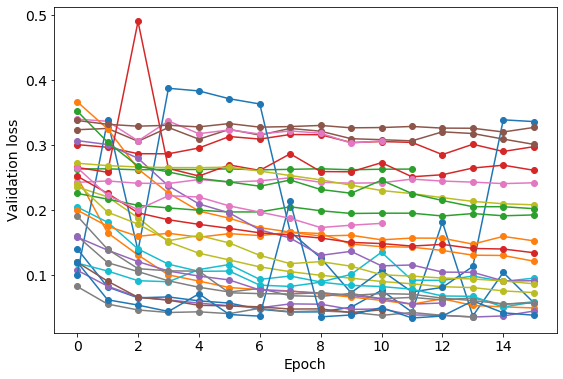

In [9]:
plt.figure(figsize=(9, 6))

for result in results:
    plt.plot(result.epoch, result.valid_loss, 'o-')

#plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Validation loss');

In [13]:
# Make the summary table
summaries = pd.DataFrame([make_summary(c, r) for (c, r) in zip(configs, results)])
summaries.sort_values('valid_loss')

,n_ranks,batch_size,real_weight,model,n_edge_layers,n_node_layers,hidden_dim,n_graph_iters,lr,weight_decay,train_loss,valid_loss,last_valid_loss,last_epoch,best_epoch
20,8,1,1.590228,mpnn,4,1,256,7,0.00100,0.000754,0.055895,0.033259,0.037546,15,11
4,8,1,3.000000,agnn,4,4,32,8,0.00100,0.000100,0.064565,0.034693,0.043916,15,13
7,8,1,3.727151,agnn,2,2,128,15,0.00100,0.000328,0.069510,0.034954,0.034954,13,13
0,8,1,3.000000,agnn,4,4,32,8,0.00100,0.000100,0.066020,0.036443,0.056855,15,13
15,8,1,5.733022,agnn,4,2,256,6,0.00010,0.000175,0.087818,0.041677,0.045809,10,9
1,8,1,2.883365,agnn,2,8,64,8,0.00010,0.000586,0.083152,0.048717,0.048717,15,15
19,8,1,5.452273,mpnn,1,2,64,11,0.00100,0.000201,0.111997,0.049964,0.057980,15,14
17,8,1,3.000000,mpnn,4,4,32,8,0.00100,0.000100,0.100133,0.053988,0.058018,15,14
24,8,1,2.095027,mpnn,8,2,128,15,0.00010,0.000842,0.084974,0.054557,0.056378,12,11
27,8,1,3.000000,mpnn,4,4,32,8,0.00100,0.000100,0.095512,0.054935,0.056284,15,14


## View the best performing models

In [14]:
best = summaries.valid_loss.idxmin()
best_config = configs[best]
best_result = results[best]

best_result

,lr,train_loss,l1,l2,epoch,train_time,valid_loss,valid_acc,valid_time
0,0.001,0.267978,1240.718383,8.485662,0,595.977519,0.119682,0.952000,17.466124
1,0.001,0.104872,1118.659309,8.765870,1,593.097456,0.061288,0.977765,17.273468
2,0.001,0.075996,996.690438,8.319064,2,593.016065,0.053112,0.981806,17.351055
3,0.001,0.065173,905.013735,8.068823,3,593.946922,0.043286,0.985901,17.257223
4,0.001,0.080207,938.568130,8.360452,4,592.558327,0.070497,0.974449,17.330523
5,0.001,0.062182,848.728276,7.903718,5,592.601545,0.038572,0.987798,17.258948
6,0.001,0.062533,841.799951,8.036474,6,592.685261,0.036058,0.988717,17.290184
7,0.001,0.050482,1075.664754,7.866802,7,591.610139,0.213003,0.924878,17.358470
8,0.001,0.057267,761.075892,7.629948,8,592.456287,0.035033,0.989361,17.358021
9,0.001,0.062710,769.673921,7.571825,9,591.905471,0.037848,0.988069,17.352389


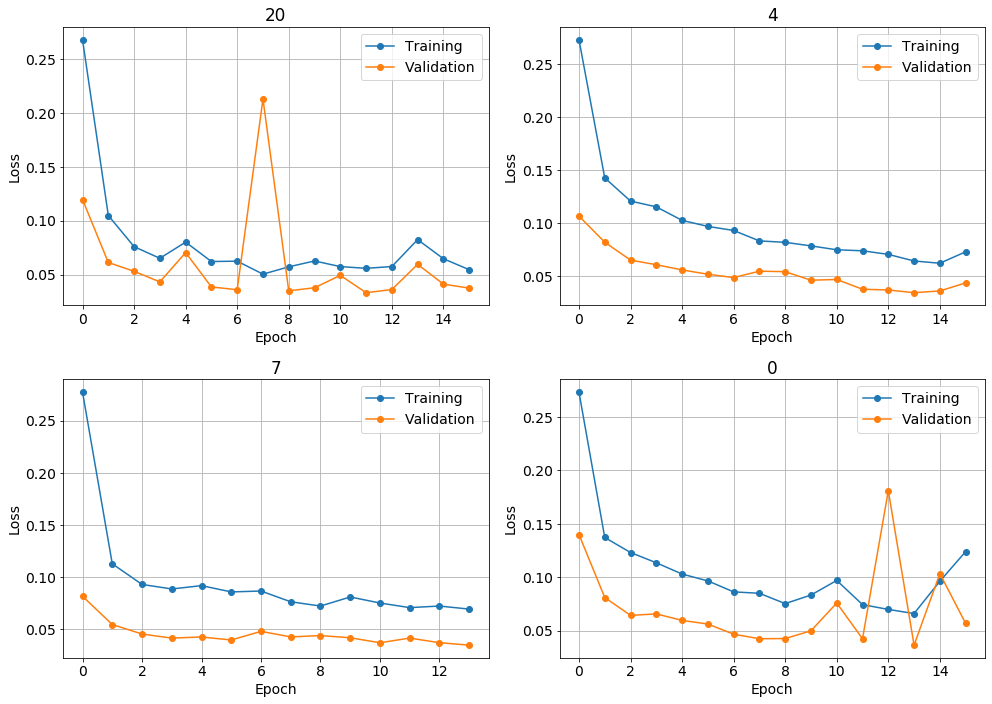

In [15]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))

for i, ax in zip(summaries.sort_values('valid_loss').index, axs.flatten()):
    
    result = results[i]
    ax.set_title(i)
    
    ax.plot(result.epoch, result.train_loss, 'o-', label='Training')
    ax.plot(result.epoch, result.valid_loss, 'o-', label='Validation')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend(loc=0)
    ax.grid()

plt.tight_layout()

## Runtime statistics

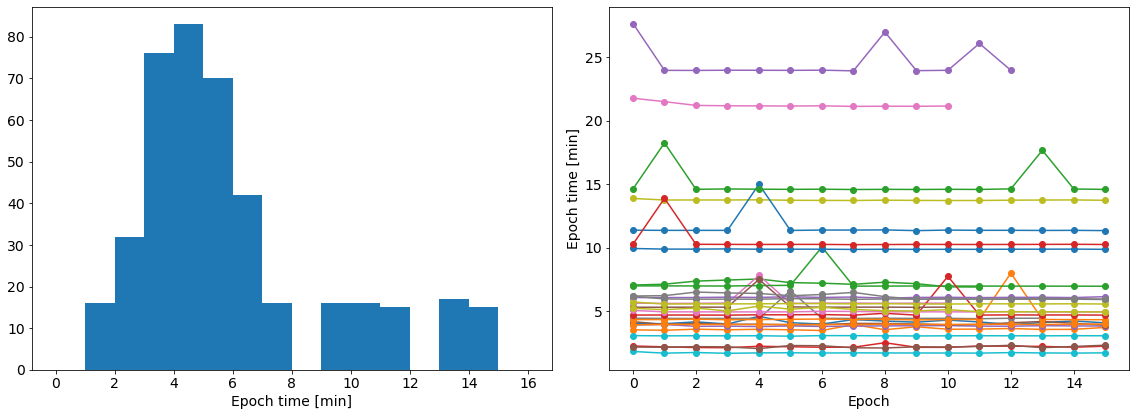

In [16]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(16, 6))

# Histogram of all epoch times
all_epoch_times = pd.concat([r.train_time/60 for r in results], ignore_index=True)
ax0.hist(all_epoch_times, bins=16, range=(0, 16))
ax0.set_xlabel('Epoch time [min]')

# Epoch time vs epoch for each result
for r in results:
    ax1.plot(r.epoch, r.train_time/60, 'o-')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Epoch time [min]')

plt.tight_layout()